# Import libraries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import emoji
import pyarabic.araby as araby
from nltk.corpus import stopwords
from pyarabic import normalize
import re
import string

In [2]:
# settings
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# Step 1: Data Understanding

## load the data

In [3]:
# df = pd.read_csv("/kaggle/input/dataset-two/dateset_(with_second_round).csv")
df = pd.read_csv("/kaggle/input/dataset-three/dateset_(with_second_round_real_fake).csv")
print(df.shape)

(1460, 12)


# Dataset Description

In [4]:
# distribution of fake and real news across years
temp_df = df[['date', 'label']].copy()

temp_df['date'] = pd.to_datetime(temp_df['date'], errors='coerce')
temp_df['year'] = temp_df['date'].dt.year
temp_df['label_name'] = temp_df['label'].map({1: 'Fake', 0: 'Real'})
year_distribution = pd.crosstab(temp_df['year'], temp_df['label_name'])
year_distribution['Total'] = year_distribution.sum(axis=1)

year_distribution

label_name,Fake,Real,Total
year,,,
2023.0,170,51,221
2024.0,278,81,359
2025.0,445,221,666


In [5]:
fake_news_articles = df[df["label"] == 1]["news_id"].nunique()
print(f"number of fake news article from fact-checking websites: {fake_news_articles}")

number of fake news article from fact-checking websites: 367


In [6]:
condition = df["label"] == 1
print(f"collected fake news: {condition.sum()}")
print(f"collected real news: {df.shape[0]-condition.sum()}")

collected fake news: 899
collected real news: 561


In [7]:
#  Corpus Statistics on texual content

def corpus_stats(text_series):
    texts = text_series.dropna().astype(str)

    total_tweets = texts.shape[0]
    words = texts.str.split().explode()
    
    total_words = words.shape[0]
    unique_words = words.nunique()
    total_characters = texts.str.len().sum()

    return total_tweets, total_words, unique_words, total_characters


# Split dataset
fake_texts = df[df["label"] == 1]["text"]
real_texts = df[df["label"] == 0]["text"]

# Compute stats
fake_stats = corpus_stats(fake_texts)
real_stats = corpus_stats(real_texts)

# Build summary table
corpus_table = pd.DataFrame({
    "Fake Posts": fake_stats,
    "Real Posts": real_stats
}, index=[
    "Total Posts",
    "Total Words",
    "Unique Words",
    "Total Characters"
])

# Add total column
corpus_table["Total Tweets"] = corpus_table.sum(axis=1)

corpus_table

,Fake Posts,Real Posts,Total Tweets
Total Posts,898,561,1459
Total Words,29070,19794,48864
Unique Words,9264,7302,16566
Total Characters,182147,131327,313474


In [8]:
# Create dataset schema table
columns_table = pd.DataFrame({
    "Column Name": df.columns,
    "Description": [
        "identifies the source news of the post.",
        "Textual content of the social media post",
        "Number of likes received by the post",
        "Number of shares or reposts",
        "Number of comments or replies",
        "Indicator of whether content is viewable (Image or Video)",
        "Username of the account that posted the news",
        "User profile URL ",
        "Social media platform (Facebook or X)",
        "Direct URL of the post",
        "Date when the post was published",
        "Binary label indicating fake (1) or real news (0)"
    ]
})

columns_table

,Column Name,Description
0,news_id,identifies the source news of the post.
1,text,Textual content of the social media post
2,likes,Number of likes received by the post
3,shares,Number of shares or reposts
4,comments,Number of comments or replies
5,viewable_content,Indicator of whether content is viewable (Imag...
6,username,Username of the account that posted the news
7,user_profile,User profile URL
8,social_media,Social media platform (Facebook or X)
9,post_url,Direct URL of the post


In [9]:

# df["label"].map({0: "Real", 1: "Fake"}).value_counts().sort_index().plot(
#     kind="pie",
#     autopct="%1.1f%%",
#     startangle=90,
#     colors=["tomato", "skyblue"],
#     ylabel=""  # removes default 'label' title
# )

# condition = df["label"] == 1
# print(condition.sum())

In [10]:
df.columns

Index(['news_id', 'text', 'likes', 'shares', 'comments', 'viewable_content',
       'username', 'user_profile', 'social_media', 'post_url', 'date',
       'label'],
      dtype='object')

## Modifying the type and the name of the columns (if necessary)

- in the case of like,shares, and comments columns , if there is no value in one of these columns that means it is zero, therefore we should convert all the NaN values in these columns to zero.

In [11]:
int_columns = ['news_id','label']
int_columns_eng = ['likes','shares','comments']
str_columns = ['text','viewable_content', 'username','user_profile', 'social_media', 'post_url']
date_columns = ['date']

for col in int_columns:
    df[col] = df[col].astype("Int64")

for col in int_columns_eng:
    df[col] = df[col].fillna(0).astype(int)
    
for col in str_columns:
    df[col] = df[col].astype('string')
    
for col in date_columns:
    df[col] = df[col].str.replace('-', '/', regex=False)
    df[col] = pd.to_datetime(df[col],format="%Y/%m/%d", errors="coerce")

In [12]:
df.head()

,news_id,text,likes,shares,comments,viewable_content,username,user_profile,social_media,post_url,date,label
0,1388,وزير التعليم بالنيل الابيض مخاطباً المعلمين ال...,15,26,33,video,معلمو ومعلمات ولاية الخرطوم,https://www.facebook.com/groups/69046538735127...,facebook,https://www.facebook.com/reel/1463711734872117,2025-09-16,1
1,82,"تحالف ""ميثاق السودان التأسيسي"" يعقد ندوة في ال...",3100,99,1,image,الجزيرة - السودان,https://www.facebook.com/AJA.Sudan?__tn__=-UC*F,facebook,https://www.facebook.com/share/1BfKyEYmzK/,2025-02-26,1
2,258,الرئيس السوداني الأسبق عمر البشير يخرج من مستش...,590,6,142,image,دارفور نيوز,https://www.facebook.com/Fur24?__tn__=-UC*F,facebook,https://web.facebook.com/photo?fbid=8060099348...,2024-03-09,1
3,1340,علينا أن نعلم أن #الكتائب_الإسلامية تسعى للسيط...,0,0,0,video,رحمة عبد الرحيم,https://x.com/Naayrouzz,X,https://twitter.com/SU19642632/status/16617081...,2023-05-26,1
4,826,"عاجل.. مصادر بقوات الدعم السريع لـ""سودان تربيو...",212,5,50,<NA>,SudanTribune_AR,https://www.x.com/SudanTribune_AR,X,https://www.x.com/SudanTribune_AR/status/18440...,2024-10-09,0


In [13]:
df.dtypes

news_id                      Int64
text                string[python]
likes                        int64
shares                       int64
comments                     int64
viewable_content    string[python]
username            string[python]
user_profile        string[python]
social_media        string[python]
post_url            string[python]
date                datetime64[ns]
label                        Int64
dtype: object

In [14]:
df.describe()

,news_id,likes,shares,comments,date,label
count,1454.0,1460.000000,1460.000000,1460.000000,1454,1460.0
mean,817.459422,624.208904,115.708219,75.828082,2024-11-20 14:26:34.497936640,0.615753
min,1.0,0.000000,0.000000,0.000000,2021-10-31 00:00:00,0.0
25%,303.5,7.000000,0.000000,1.000000,2024-04-30 00:00:00,0.0
50%,895.5,94.000000,10.000000,9.000000,2025-01-29 00:00:00,1.0
75%,1251.0,335.250000,57.000000,30.000000,2025-07-20 18:00:00,1.0
max,1483.0,88000.000000,22531.000000,8223.000000,2025-10-30 00:00:00,1.0
std,461.405899,3786.424580,941.559648,400.218275,NaN,0.486583


# Step 2: Initial Data preperation

## Drop columns
- we will drop the columns that are not in interest in the current time:

In [15]:
df.columns

Index(['news_id', 'text', 'likes', 'shares', 'comments', 'viewable_content',
       'username', 'user_profile', 'social_media', 'post_url', 'date',
       'label'],
      dtype='object')

In [16]:
drop_columns = ["social_media","user_profile",'post_url']
df.drop(drop_columns,axis=1,inplace=True)
#df.head()

investigating the amount of null values in our dataset:

In [17]:
df.isna().sum()

news_id               6
text                  1
likes                 0
shares                0
comments              0
viewable_content    501
username             68
date                  6
label                 0
dtype: int64

## Drop rows
we will drop rows (if necessary) after checking:
- duplicates rows
- remove English words and Urls from the text field, then drop rows with empty text field
- rows before the date of the war

see if there is duplicated rows in the dataset or not, and drop them if exist:

In [18]:
print("number of duplicated rows are: ",df.duplicated().sum())
# df.loc[df.duplicated()]

number of duplicated rows are:  32


In [19]:
# drop duplicated rows
df = df[~df.duplicated()].reset_index(drop=True).copy()
df.shape

(1428, 9)

In [20]:
# # Drop the username column after we use it to identify truly duplicated columns
# df.drop(columns=["username"],axis=1,inplace=True)

Check if there are rows with dates before "2023-04-15"

In [21]:
condition = df["date"] < "2023-04-15"
print("number of rows with date before the war: ",condition.sum())
df[condition].head()

# drop them
df = df[~condition].copy().reset_index(drop=True)
print(f"size of the data set are : {df.shape}")

number of rows with date before the war:  2
size of the data set are : (1426, 9)


### Initial preprocessing for news text content

- In the next section we will study each feature and investigate if it has a significant relationship with the label column (fake and real).
- Therefore, we will make an initial preprocessing for the text content and compute the desired features for further investigations.
- Candidate derived features to investigate further are:
    
    - quantity features:
        - number of hashtags in the text 
        - number of emojis
        - number of stopwords 
        - number of words (text length)
        - number of punctions
        - number of numeric sequences
          
    - Temporal features:
        - year , mounth, day, name of the day

- we should first porccess arabic text in several steps, they are:
1. remove english letter and Urls:
   - (Then count emojis,hashtags, punctions, numeric sequences columns)
3. removing non-arabic letters
2. remove emojis    
3. normalization, it includes:
   - letter replacement (Convert different forms of the same letter to one common form)
   - remove diacritics
   - Remove \r, \n, \t, and other whitespace characters
   - Reduce repeated letters (then count stopwords column)
4. removing stopwords:
   -  Before removing, we will count the stopword occurrences for each news
   -  count the number of words in text
5. Lemmatization or stemming:
    - stemming using ArabicLightStemmer, to construct 1-2 n-gram tf-idf, and 3-5 charcter n-gram tf-idf

## Construct Quantity Derived Features

In [22]:
# remove Urls and english words from the text
df["text"] = df["text"].str.replace(r"http\S+|www\S+|https\S+", "", regex=True)
df["text"] = df["text"].str.replace(r"[A-Za-z]+", "", regex=True)

# count hashtags for each row
df["hashtag_count"] = df["text"].str.count("#")

# count emojis for each row:
df["emoji_count"] = df["text"].apply(lambda x: emoji.emoji_count(str(x)))

# Determine rows with empty text field and drop them
condition = df["text"].str.strip().replace("", pd.NA).isna()
df = df[~condition].copy().reset_index(drop=True)
print(f"{condition.sum()} rows has empty text field")


# Define Arabic and English punctuation
ARABIC_PUNCT = "،؛؟«»…“”‘’٭–—"
ENGLISH_PUNCT = string.punctuation
ALL_PUNCT = ARABIC_PUNCT + ENGLISH_PUNCT

# count punctuations for each row
def count_punctuations(text):
    return sum(1 for char in text if char in ALL_PUNCT)

df["punct_count"] = df["text"].apply(count_punctuations)
df["numeric_count"] = df["text"].apply(lambda x: len(re.findall(r'\d+',x)))

4 rows has empty text field


define functions will be used for cleaning the text:

In [23]:
arabic_stopwords = stopwords.words('arabic')    # arabic stopwords

# remove non arabic letters function
def remove_non_arabic_letters(text):
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)    # Unicode range for Arabic letters and characters
    text = re.sub(f"[{re.escape(ALL_PUNCT)}]", "", text)    # remove punctuation marks
    return text

# remove emojis
def remove_emojis(text):
    text = emoji.replace_emoji(text, replace=' ')
    return text

# remove stopwords function
def remove_stopwords(text,stopwords):
    text_words = text.split()
    text_list = [word for word in text_words if word not in stopwords]
    return ' '.join(text_list)

def normalize_text(text):

    # First use pyarabic normalization
    text = normalize.normalize_searchtext(text)
    # Additional custom normalization
    text = re.sub(r'[ٰ]', '', text)  # Remove small alef
    text = re.sub(r'[ك]', 'ك', text)  # Normalize kaf
    text = re.sub(r'[ى]', 'ي', text)  # Normalize alef maqsura to ya
    text = re.sub(r'[ة]', 'ه', text)  # Normalize ta marbuta to ha
    
    # Remove \r, \n, \t, and other whitespace characters
    re.sub(r'\s', ' ', text)
    # Replace any character repeated 3 or more times with a single occurrence
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    return text


def count_arabic_stopwords(text, stopwords):
    words = text.split()
    count = sum(1 for w in words if w in stopwords)
    return count

In [24]:
# remove non arabic text
df["text"] = df["text"].apply(remove_non_arabic_letters)

#remove emojis
df["text"] = df["text"].apply(remove_emojis)

# normalize text
df["text"] = df["text"].apply(normalize_text)


# count the stoping words in each news
normalized_stopwords = list(map(normalize_text,arabic_stopwords))

df["stopwords_count"] = df["text"].apply(
    lambda text: count_arabic_stopwords(text, normalized_stopwords)
)

# remove stopwords
df["text"] = df["text"].apply(
    lambda text: remove_stopwords(text,normalized_stopwords)
)

In [25]:
# Determine rows with empty text field and drop them
condition = df["text"].str.strip().replace("", pd.NA).isna()
df = df[~condition].copy().reset_index(drop=True)

print(f"{condition.sum()} rows has empty text field after processing the text content")
df.shape

32 rows has empty text field after processing the text content


(1390, 14)

## Stemming text content

In [26]:
!pip install tashaphyne
from tashaphyne.stemming import ArabicLightStemmer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 5.9 MB/s eta 0:00:00


number of words in the entire text column:

In [27]:
all_words_count  = sum(df["text"].apply(lambda x: len(str(x).split())))

print("number of words in the text column: ",all_words_count)

number of words in the text column:  36173


The Vocabulary size before stemming:

In [28]:
import re

# Build vocabulary
vocab_before = set()

for text in df["text"].dropna():
    vocab_before.update(text.split())

print("Vocabulary size before stemming:", len(vocab_before))
#10536
#10539

Vocabulary size before stemming: 10704


The Vocabulary size after stemming:

In [29]:
from tashaphyne.stemming import ArabicLightStemmer


def Arabic_Light_Stemmer(text):
    Arabic_Stemmer = ArabicLightStemmer()
    # Handle NaN or non-string
    if not isinstance(text, str):
        return ""
    # Tokenize properly
    tokens = text.split()
    stems = []
    for token in tokens:
        Arabic_Stemmer.light_stem(token)
        stems.append(Arabic_Stemmer.get_stem())
    return stems

vocab_after = set()

for text in df["text"].dropna():
    vocab_after.update(Arabic_Light_Stemmer(text))

print("Vocabulary size after stemming:", len(vocab_after))

Vocabulary size after stemming: 5703


In [30]:
reduction_ratio = 1 - (len(vocab_after) / len(vocab_before))
print(f"Vocabulary reduction: {reduction_ratio:.2%}")

Vocabulary reduction: 46.72%


Applying the ArabicLightStemmer from the Tashaphyne library reduced the vocabulary size from 10536 tokens to 5628 tokens, corresponding to a 46.58% reduction. This normalization helps mitigate lexical sparsity while retaining the semantic meaning of words, which is particularly useful for training text classification models.

In [31]:
df["text_stem"] = df["text"].apply(lambda x: " ".join(Arabic_Light_Stemmer(x)))

In [32]:
i = 0
print("without stemming: ",df["text"].iloc[i])
print("with stemming: ",df["text_stem"].iloc[i])

without stemming:  وزير التعليم بالنيل الابيض مخاطبا المعلمين المحتجين تردا البيءه التعليميه وعلا عدم تسلمهم رواتبهم اشهراسمعوا حل الوزير للمشكله اضربوا بكرهنرفدكم ونجيب غيركم
with stemming:  زير تعليم نيل ابيض مخاطب معلم محتج رد بيءه تعليميه عل عدم سلم رواتب اشهراسمعوا حل وزير مشكله ضرب كرهنرفد جيب غير


## Construct the text length feature:

In [33]:
df["word_count"] = df["text_stem"].apply(lambda x: len(str(x).split()))

## Construct Temporal Derived Features

In [34]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["day_name"] = df["date"].dt.day_name()
df["day_of_week"] = df["date"].dt.weekday

In [35]:
df.dtypes

news_id                      Int64
text                        object
likes                        int64
shares                       int64
comments                     int64
viewable_content    string[python]
username            string[python]
date                datetime64[ns]
label                        Int64
hashtag_count                Int64
emoji_count                  int64
punct_count                  int64
numeric_count                int64
stopwords_count              int64
text_stem                   object
word_count                   int64
year                       float64
month                      float64
day                        float64
day_name                    object
day_of_week                float64
dtype: object

In [36]:
df.head()

,news_id,text,likes,shares,comments,viewable_content,username,date,label,hashtag_count,emoji_count,punct_count,numeric_count,stopwords_count,text_stem,word_count,year,month,day,day_name,day_of_week
0,1388,وزير التعليم بالنيل الابيض مخاطبا المعلمين الم...,15,26,33,video,معلمو ومعلمات ولاية الخرطوم,2025-09-16,1,0,0,8,0,3,زير تعليم نيل ابيض مخاطب معلم محتج رد بيءه تعل...,22,2025.0,9.0,16.0,Tuesday,1.0
1,82,تحالف ميثاق السودان التاسيسي يعقد ندوه البرلما...,3100,99,1,image,الجزيرة - السودان,2025-02-26,1,1,0,4,0,2,حالف ميثاق سود تاسيس عقد دو برلم بريطان شان او...,12,2025.0,2.0,26.0,Wednesday,2.0
2,258,الرءيس السوداني الاسبق عمر البشير يخرج مستشفي ...,590,6,142,image,دارفور نيوز,2024-03-09,1,2,0,6,1,3,رءيس سودان اسبق عمر بشير خرج مستشف علياء سلاح ...,16,2024.0,3.0,9.0,Saturday,5.0
3,1340,علينا نعلم الكتاءبالاسلاميه تسعا للسيطره المجت...,0,0,0,video,رحمة عبد الرحيم,2023-05-26,1,2,0,4,0,6,على علم الكتاءبالاسلاميه سع سيطره مجتمع فرض رء...,17,2023.0,5.0,26.0,Friday,4.0
4,826,عاجل مصادر بقوات الدعم السريع لسودان تربيون حم...,212,5,50,<NA>,SudanTribune_AR,2024-10-09,0,0,0,5,0,2,عاجل مصادر قو دعم سريع سودا ربي حميد عل دء عمل...,17,2024.0,10.0,9.0,Wednesday,2.0


In [37]:
import pandas as pd

# Create DataFrame from your data
data = {
    'Feature': ['likes', 'shares', 'comments', 'hashtag_count', 'emoji_count', 
                'punct_count', 'numeric_count', 'stopwords_count', 'word_count'],
    'Range_Original': [88000, 22531, 8223, 27, 39, 643, 29, 131, 398],
    'Range_Scaled': [28.989, 25.643, 21.600, 13.459, 15.820, 29.415, 17.721, 14.061, 12.297]
}

df_table = pd.DataFrame(data)
df_table.set_index('Feature', inplace=True)

# Display with formatting
print("=" * 50)
print("RANGE COMPARISON: ORIGINAL vs SCALED FEATURES")
print("=" * 50)
print(df_table.to_string(float_format=lambda x: f'{x:.3f}' if isinstance(x, float) else str(x)))

RANGE COMPARISON: ORIGINAL vs SCALED FEATURES
                 Range_Original  Range_Scaled
Feature                                      
likes                     88000        28.989
shares                    22531        25.643
comments                   8223        21.600
hashtag_count                27        13.459
emoji_count                  39        15.820
punct_count                 643        29.415
numeric_count                29        17.721
stopwords_count             131        14.061
word_count                  398        12.297


# Step 3: Feature Undestanding

In this section there are serveral question we want to answer:
1. Raito between real and fake news
2. distribution of real news from different sources
3. Relationship between viewable content and the label columns
4. distribution of real and fake news over time
5. Relationship between the different quantity features and the label column:
   - hashtag counts
   - emoji counts
   - stop words counts
   - punctuation counts
   - word counts
   - numbers counts
6. Relationship between the engagement matrix and the labels
7. Relationship between temporal features and the label
8. Top 10 word used in both real and fake news

### Raito between real and fake news:

<Axes: >

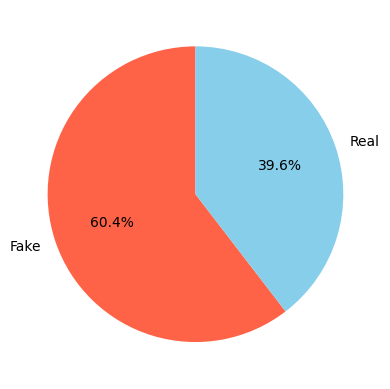

In [38]:

df["label"].map({0: "Real", 1: "Fake"}).value_counts().sort_index().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    colors=["tomato", "skyblue"],
    ylabel=""  # removes default 'label' title
)

### distribution of real news from different sources
- we collected real news from 11 sources

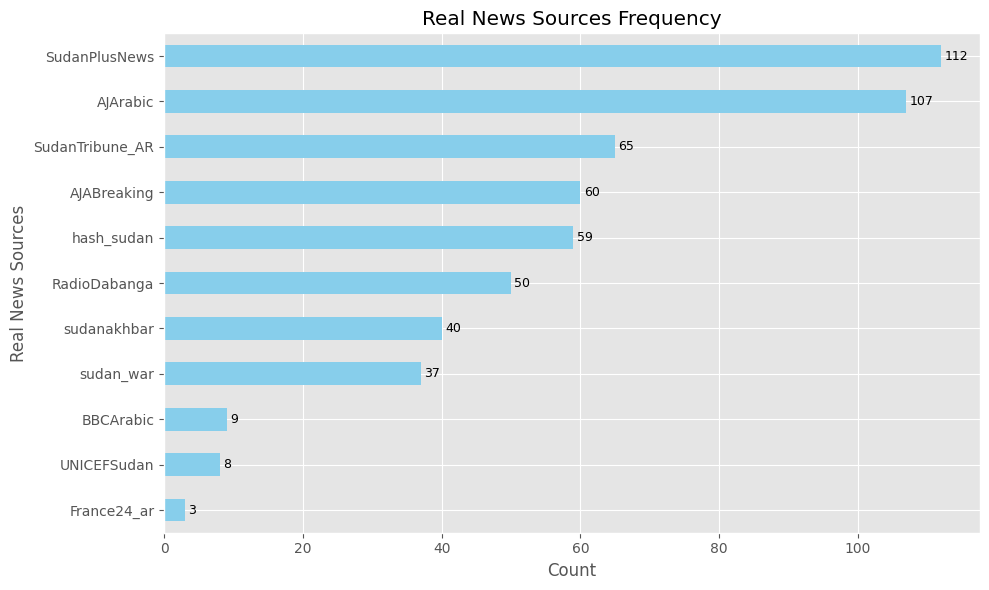

In [39]:
condition = df["label"] == 0
counts = df.loc[condition, "username"].value_counts()


counts = counts.sort_values(ascending=True)

ax = counts.plot(
    kind='barh',
    figsize=(10, 6),
    title="Real News Sources Frequency",
    color="skyblue"
)

plt.xlabel("Count")
plt.ylabel("Real News Sources")


for i, v in enumerate(counts):
    ax.text(v + 0.5, i, str(v), va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

### Relationship between viewable content and the label columns

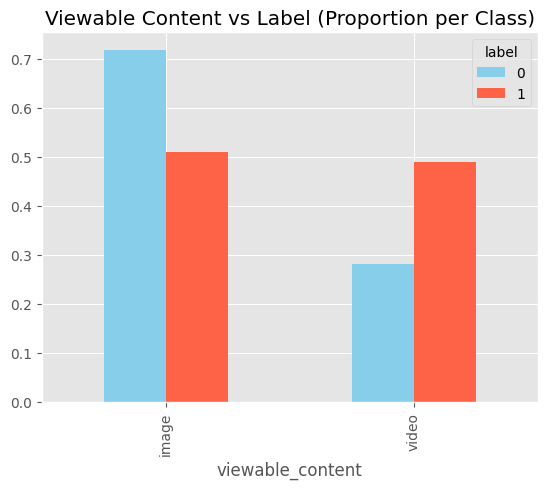

In [40]:
label_colors = {0:"skyblue",1:"tomato"}
pd.crosstab(df["viewable_content"], df["label"], normalize='columns').plot(kind='bar',color=label_colors)
plt.title("Viewable Content vs Label (Proportion per Class)")
plt.show()

In [41]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df["viewable_content"], df["label"])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square test p-value:", p)

Chi-square test p-value: 2.7481728736994092e-05


p < 0.05 , therefore there is strong evidence of association between viewable content on the post and the label column.

### distribution of real and fake news over time

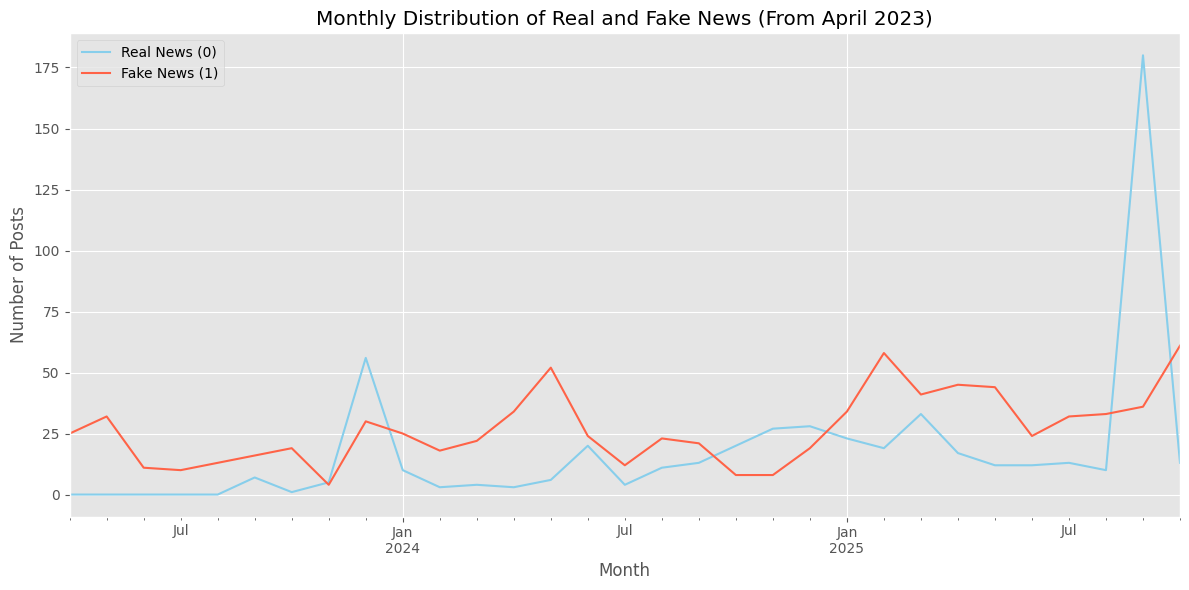

In [42]:
import matplotlib.pyplot as plt
import pandas as pd


# Group by date + label, then resample by month
timeline = df.groupby(["date", "label"]).size().unstack(fill_value=0)
timeline_monthly = timeline.resample("ME").sum()

# Plot
timeline_monthly.plot(figsize=(12,6),color=label_colors)
plt.title("Monthly Distribution of Real and Fake News (From April 2023)")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.legend(["Real News (0)", "Fake News (1)"])
plt.tight_layout()
plt.show()

## Investigate the relationship between quantity-derived features and the label column

Here we want to investigate if there is a relationship between the quantity-derived features that appear in the text column and the classification of the news.

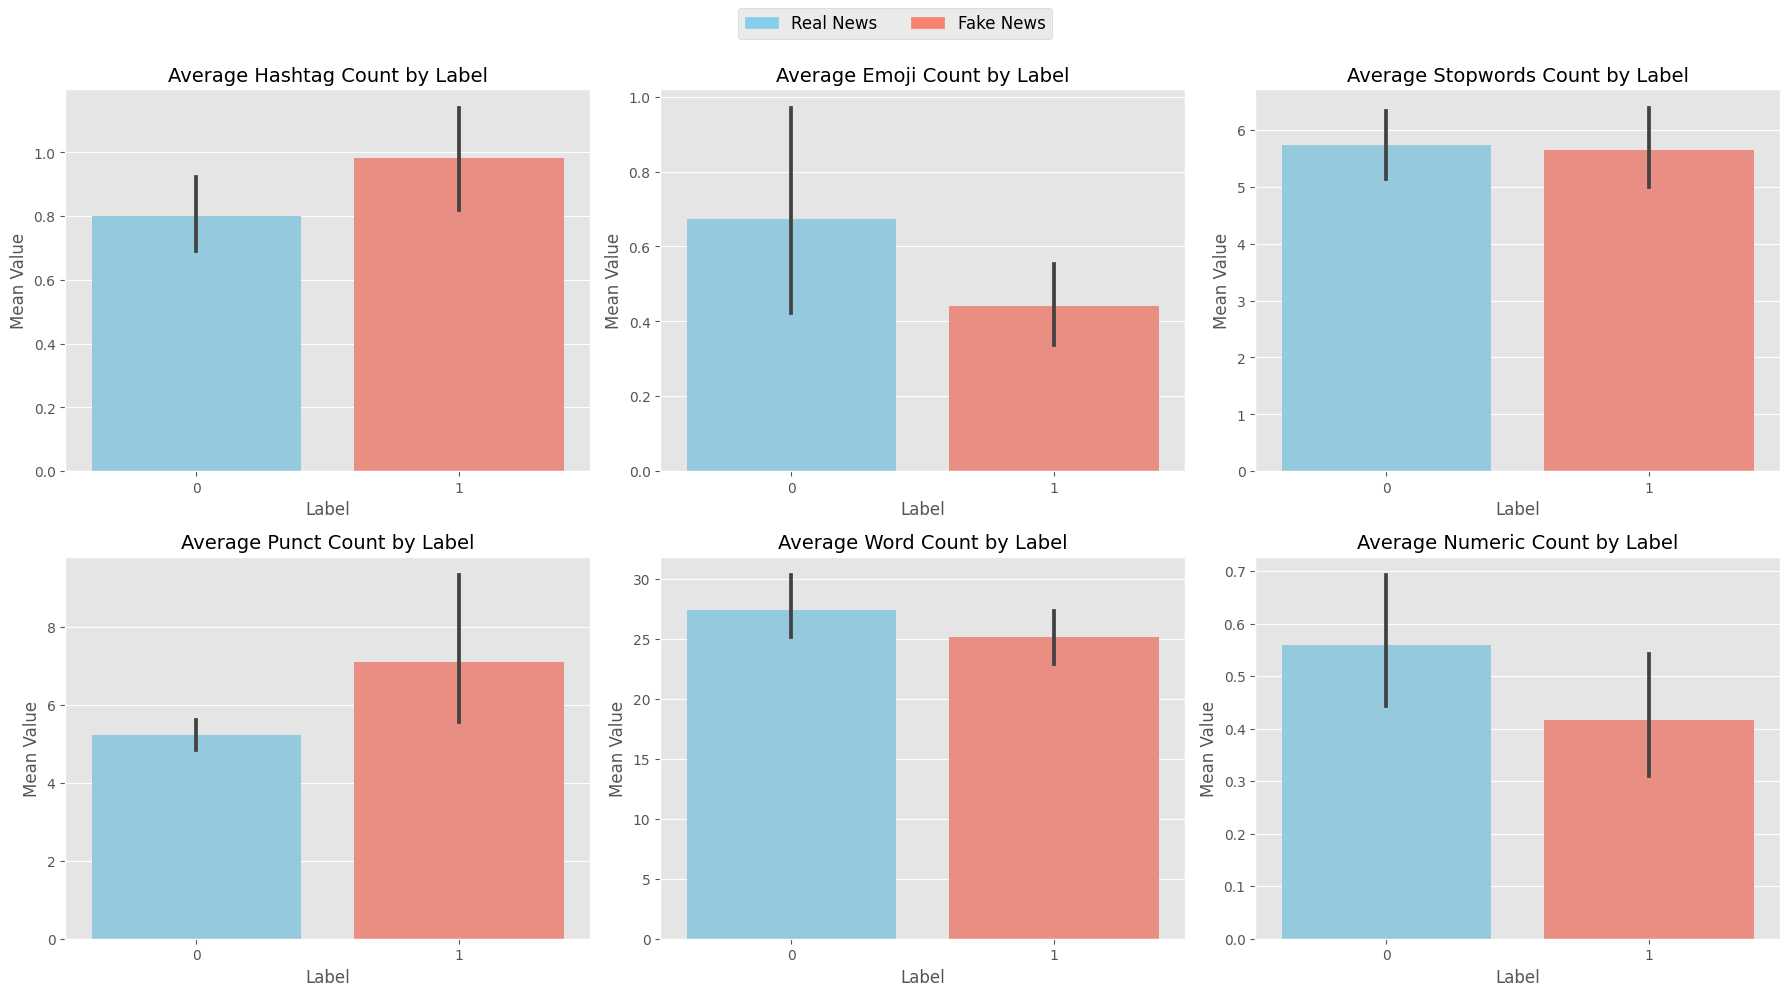

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

quant_features = ['hashtag_count','emoji_count','stopwords_count','punct_count','word_count','numeric_count']
label_colors = {0: 'skyblue', 1: 'salmon'}  # 0=Real, 1=Fake

# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, f in enumerate(quant_features):
    sns.barplot(
        x="label", 
        y=f, 
        data=df, 
        estimator="mean", 
        palette=label_colors,
        ax=axes[i]
    )
    axes[i].set_title(f"Average {f.replace('_',' ').title()} by Label", fontsize=14)
    axes[i].set_xlabel("Label")
    axes[i].set_ylabel("Mean Value")

# Add a single legend for the whole figure
import matplotlib.patches as mpatches
real_patch = mpatches.Patch(color='skyblue', label='Real News')
fake_patch = mpatches.Patch(color='salmon', label='Fake News')
fig.legend(handles=[real_patch, fake_patch], loc='upper center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the legend
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

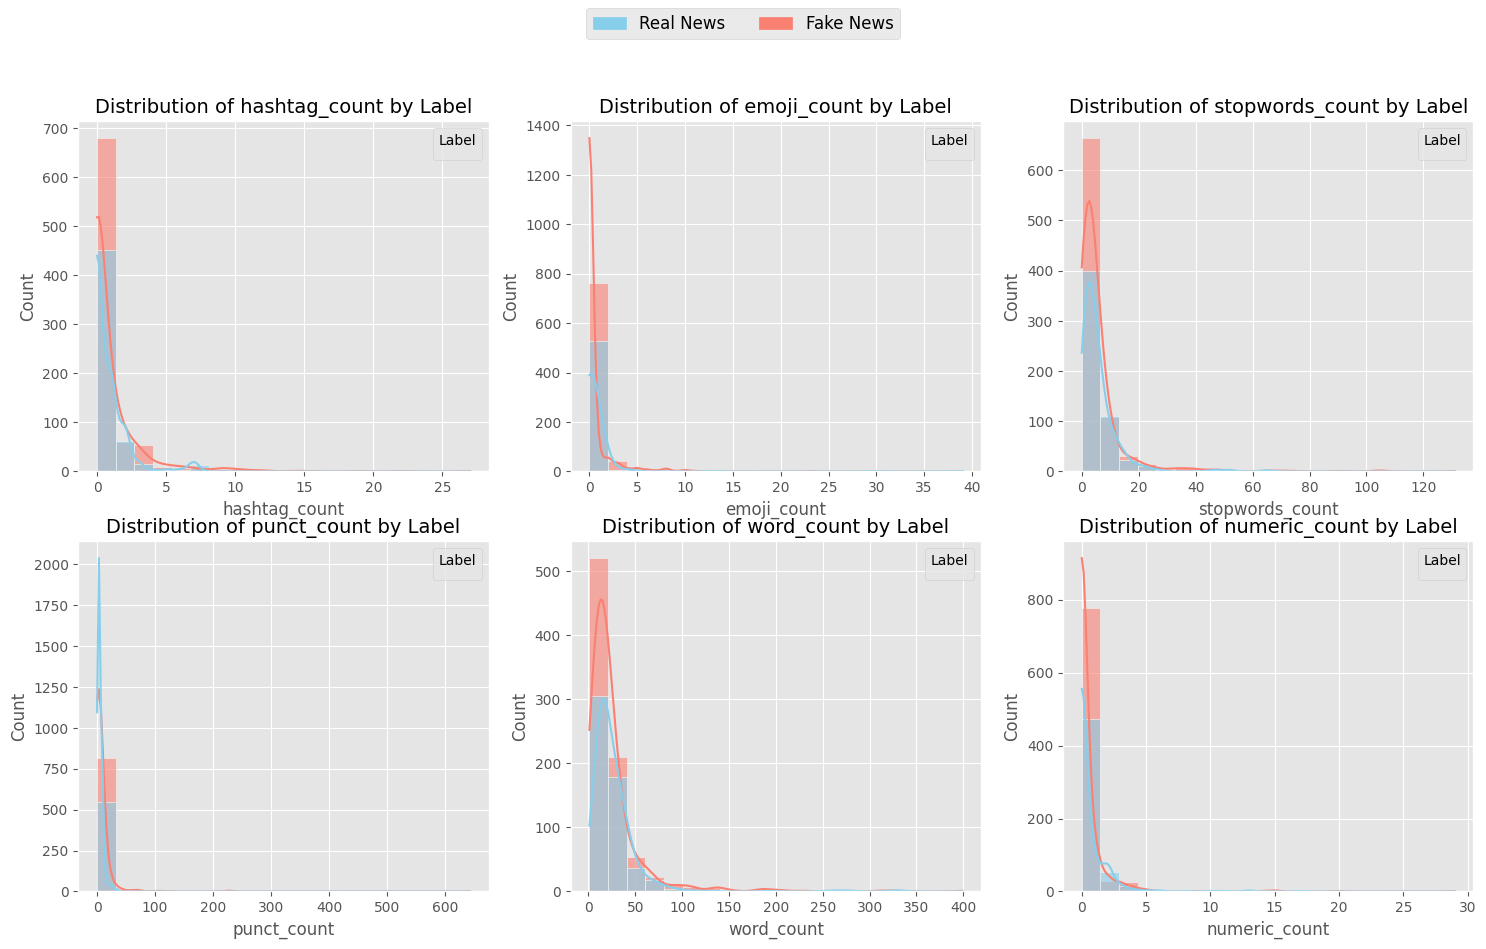

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

n_features = len(quant_features)

# Create a grid of subplots (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # adjust size for readability
axes = axes.flatten()  # flatten to iterate easily

# Color palette for labels
palette = {0: 'skyblue', 1: 'salmon'}

for i, f in enumerate(quant_features):
    sns.histplot(
        data=df, 
        x=f, 
        hue='label', 
        kde=True, 
        ax=axes[i],
        palette=palette,
        alpha=0.6,  # transparency for overlapping
        bins=20     # adjust number of bins
    )
    axes[i].set_title(f'Distribution of {f} by Label', fontsize=14)
    axes[i].set_xlabel(f)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Label')


fig.legend(handles=[real_patch, fake_patch], loc='upper center', ncol=2, fontsize=12)

plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

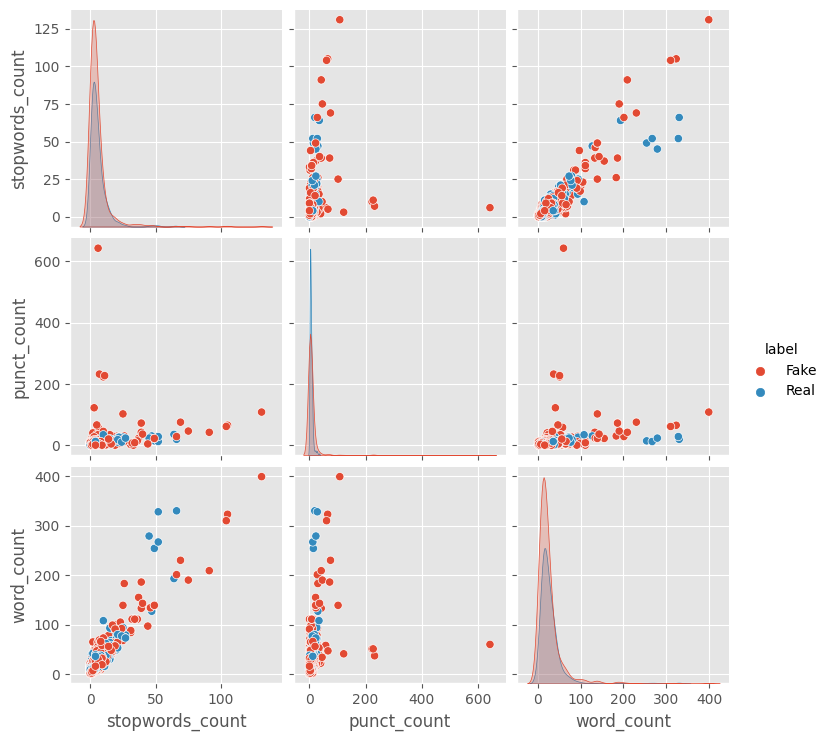

In [45]:
cols = ["stopwords_count", "punct_count", "word_count"]

temp_df = df[cols + ["label"]].copy()

# Convert numeric columns only
temp_df[cols] = temp_df[cols].astype(float)

# Map labels for display only
temp_df["label"] = temp_df["label"].map({0: "Real", 1: "Fake"})

# Drop rows with missing values for plotting
temp_df = temp_df.dropna()

sns.pairplot(temp_df, vars=cols, hue="label")
plt.show()

In [46]:
df.columns

Index(['news_id', 'text', 'likes', 'shares', 'comments', 'viewable_content',
       'username', 'date', 'label', 'hashtag_count', 'emoji_count',
       'punct_count', 'numeric_count', 'stopwords_count', 'text_stem',
       'word_count', 'year', 'month', 'day', 'day_name', 'day_of_week'],
      dtype='object')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

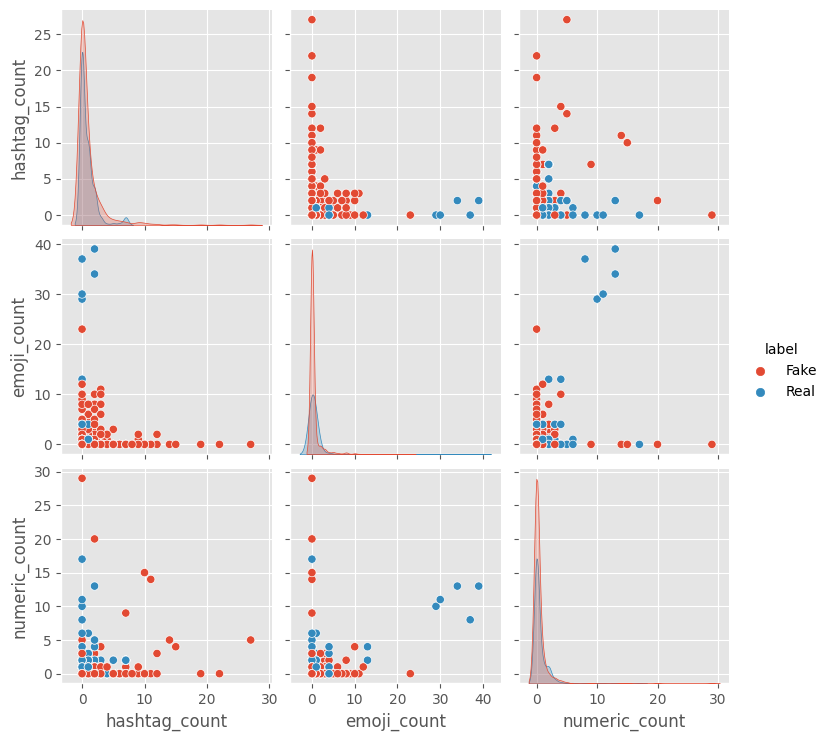

In [47]:
cols = ['hashtag_count', 'emoji_count', 'numeric_count']

temp_df = df[cols + ["label"]].copy()

# Convert numeric columns only
temp_df[cols] = temp_df[cols].astype(float)

# Map labels for display only
temp_df["label"] = temp_df["label"].map({0: "Real", 1: "Fake"})

# Drop rows with missing values for plotting
temp_df = temp_df.dropna()

sns.pairplot(temp_df, vars=cols, hue="label")
plt.show()

In [48]:
from scipy.stats import shapiro

for f in quant_features:
    stat, p = shapiro(df[f])
    print(f"{f}: p={p:.3f} -> {'normal' if p>0.05 else 'not normal'}")

hashtag_count: p=0.000 -> not normal
emoji_count: p=0.000 -> not normal
stopwords_count: p=0.000 -> not normal
punct_count: p=0.000 -> not normal
word_count: p=0.000 -> not normal
numeric_count: p=0.000 -> not normal


Since these features are not normally distributed.Hence a non-parametric method will be used

In [49]:
from scipy.stats import mannwhitneyu

for f in quant_features:
    group0 = df[df['label']==0][f]
    group1 = df[df['label']==1][f]
    stat, p = mannwhitneyu(group0, group1)
    print(f"{f}: Mann-Whitney U p={p:.3f}")

hashtag_count: Mann-Whitney U p=0.061
emoji_count: Mann-Whitney U p=0.000
stopwords_count: Mann-Whitney U p=0.000
punct_count: Mann-Whitney U p=0.000
word_count: Mann-Whitney U p=0.000
numeric_count: Mann-Whitney U p=0.001


The null hypothesis (H₀) of the test is:

- There is no difference in the distribution of the current feature between real and fake news posts.

- Since the p-value < 0.05, the null hypothesis is rejected.

- Therefore, the number of hashtags, emojis, punctuations, stop words, words and numeric sequences used in posts is significantly different between real and fake news.

In [50]:
for f in quant_features:
    desc = df.groupby("label")[f].describe()
    print(f"\nFeature: {f}")
    print(desc)


Feature: hashtag_count
       count      mean       std  min  25%  50%  75%   max
label                                                     
0      550.0  0.801818  1.385192  0.0  0.0  0.0  1.0   7.0
1      840.0  0.980952  2.323558  0.0  0.0  0.0  1.0  27.0

Feature: emoji_count
       count      mean       std  min  25%  50%  75%   max
label                                                     
0      550.0  0.674545  3.367244  0.0  0.0  0.0  1.0  39.0
1      840.0  0.440476  1.621159  0.0  0.0  0.0  0.0  23.0

Feature: stopwords_count
       count      mean        std  min  25%  50%  75%    max
label                                                       
0      550.0  5.727273   7.213008  0.0  2.0  4.0  7.0   66.0
1      840.0  5.654762  10.476142  0.0  1.0  3.0  6.0  131.0

Feature: punct_count
       count      mean        std  min  25%  50%  75%    max
label                                                       
0      550.0  5.223636   4.912994  0.0  2.0  4.0  7.0   35.0
1      

Analysis of the quantity-based features revealed notable differences between real and fake news posts. The hashtag_count feature shows that fake posts tend to include slightly more hashtags on average (mean 0.98 vs 0.84 for real) with some extreme values reaching 27, and the difference is statistically significant (Mann-Whitney U, p = 0.034). Interestingly, emoji_count is slightly higher in real posts (mean 0.76 vs 0.44), yet the distributions differ significantly (p = 0.000), indicating distinct emoji usage patterns. Stopwords, punctuation, word count, and numeric sequences also exhibit statistically significant differences (all p = 0.000), even if their mean values are close; fake posts often display higher variance and extreme values, particularly in punctuation (max 643) and stopwords (max 131). Overall, these results suggest that all six features — hashtags, emojis, stopwords, punctuation, word count, and numeric sequences — capture patterns that differentiate fake from real news and are potentially useful for classification models.

## Relationship between the engagement matrix and the labels

- First, we should check if the engagement matrix (likes, comments, shares) is normally distributed or not, to determine which statistical test we will use.
- using Shapiro–Wilk normality tests:

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

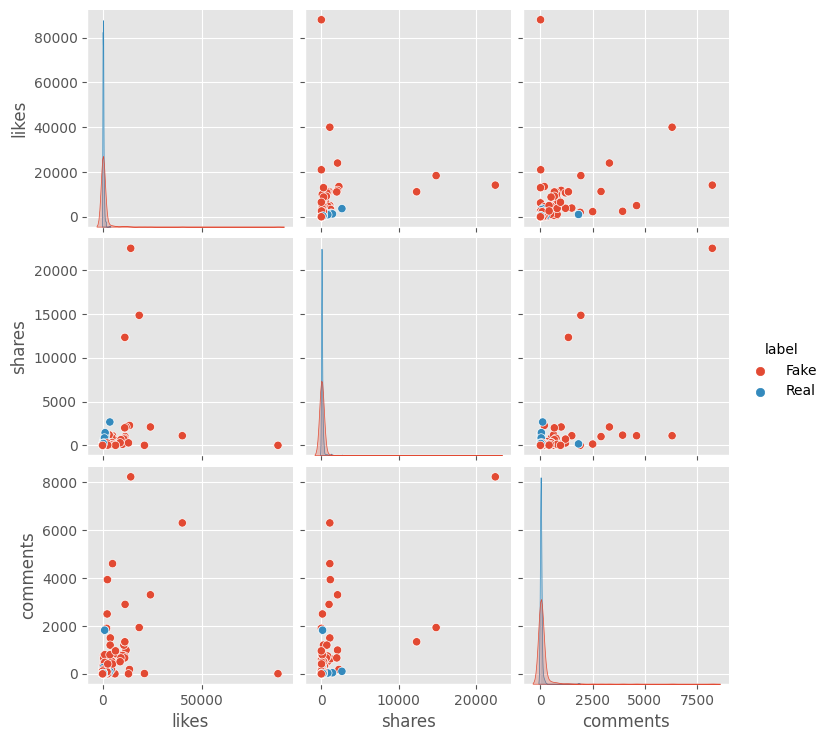

In [51]:
cols = ["likes", "shares", "comments"]

temp_df = df[cols + ["label"]].copy()

# Convert numeric columns only
temp_df[cols] = temp_df[cols].astype(float)

# Map labels for display only
temp_df["label"] = temp_df["label"].map({0: "Real", 1: "Fake"})

# Drop rows with missing values for plotting
temp_df = temp_df.dropna()

sns.pairplot(temp_df, vars=cols, hue="label")
plt.show()

In [52]:
from scipy.stats import shapiro

for col in ["likes", "shares", "comments"]:
    stat, p = shapiro(df[col].dropna())
    print(f"{col}: p-value = {p}")

likes: p-value = 5.659920720696109e-62
shares: p-value = 3.767330222233393e-63
comments: p-value = 1.538443177522928e-61


Since p-value< 0.05, None of these engagement variables are normally distributed.
Therefore a non-parametric method will be used

In [53]:
from scipy.stats import mannwhitneyu

for col in ["likes", "shares", "comments"]:
    real = df.loc[df["label"] == 0, col]
    fake = df.loc[df["label"] == 1, col]
    stat, p = mannwhitneyu(real, fake, alternative="two-sided")
    print(f"Mann-Whitney U test p-value ({col}): {p}")

Mann-Whitney U test p-value (likes): 1.3087656615437652e-06
Mann-Whitney U test p-value (shares): 9.001132195682647e-16
Mann-Whitney U test p-value (comments): 4.397356746071629e-07


- There is a statistically significant difference in the distribution of likes, shares, and comments between real and fake news posts.
- This means engagement behavior (how people interact with posts) could be a useful signal for distinguishing fake vs. real news.


Feature: likes
       count        mean          std  min  25%    50%    75%      max
label                                                                 
0      550.0  291.100000   355.472362  0.0  7.0  239.0  381.0   3647.0
1      840.0  734.285714  3886.718592  0.0  8.0   48.5  258.5  88000.0

Feature: shares
       count        mean          std  min   25%   50%    75%      max
label                                                                 
0      550.0   77.116364   185.423341  0.0  1.25  32.0  78.00   2668.0
1      840.0  126.664286  1120.506411  0.0  0.00   5.0  33.25  22531.0

Feature: comments
       count        mean         std  min  25%   50%   75%     max
label                                                             
0      550.0   25.334545  113.731512  0.0  0.0   7.0  21.0  1823.0
1      840.0  102.177381  478.857541  0.0  2.0  11.0  38.0  8223.0


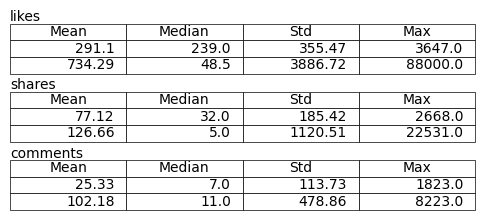

In [54]:
fig, ax = plt.subplots(3,1,figsize=(6, 2))
plt.subplots_adjust(hspace=2.9)  # increase vertical space
i=0
engag_features = ["likes", "shares", "comments"]
for f in engag_features:
    desc = df.groupby("label")[f].describe()
    print(f"\nFeature: {f}")
    print(desc)
    desc_table = desc[["mean", "50%", "std", "max"]].round(2)
    ax[i].axis("off")
    table = ax[i].table(
        cellText=desc_table.values,
        colLabels=["Mean", "Median", "Std", "Max"],
        loc="center",
    )
    ax[i].text(
    0.0, 1.9,                 # x, y in axis coordinates
    f,
    transform=ax[i].transAxes,
    va="bottom",
    ha="left"
    )

    i = i+1
plt.show()

The analysis of engagement-related features shows statistically significant differences between real and fake news posts. Likes, shares, and comments all exhibit significant distributional differences between the two classes (Mann–Whitney U test: likes p = 2.48×10⁻⁴, shares p = 3.09×10⁻¹², comments p = 3.02×10⁻⁶). Although fake news posts display substantially higher mean engagement values—particularly for likes (mean 734 vs 272 for real) and comments (mean 102 vs 27)—these averages are heavily influenced by extreme outliers, as reflected in the very large maximum values (e.g., 88,000 likes and 22,531 shares). In contrast, the median values are consistently lower for fake posts, indicating that most fake news items receive relatively modest engagement, while a small number achieve viral spread. Overall, these findings suggest that engagement features are highly skewed but still informative, capturing the tendency of fake news to occasionally attract unusually high user interaction.

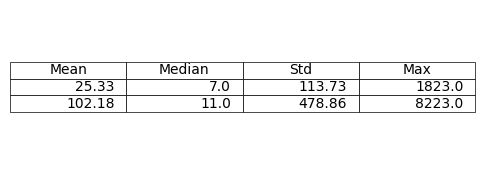

In [55]:
import matplotlib.pyplot as plt

# Pandas summary
desc = df.groupby("label")[f].describe()

desc_table = desc[["mean", "50%", "std", "max"]].round(2)
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")
table = ax.table(
    cellText=desc_table.values,
    colLabels=["Mean", "Median", "Std", "Max"],
    loc="center"
)
plt.show()

## Spearman correlation

Between quantity features:

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


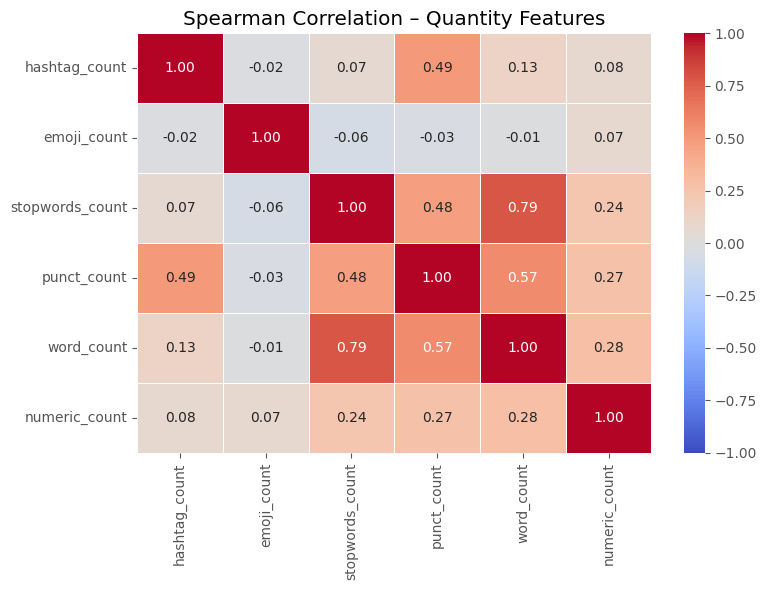

In [56]:
#fea = ['hashtag_count','emoji_count','stopwords_count','punct_count','word_count','numeric_count']
corr_quantity = df[quant_features].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_quantity,annot=True,cmap='coolwarm',
             linewidths=0.5,fmt=".2f",vmin=-1,vmax=1,center=0
)
plt.title("Spearman Correlation – Quantity Features")
plt.tight_layout()
plt.show()

The Spearman correlation analysis among the quantity-based features reveals several meaningful monotonic relationships. A strong positive correlation is observed between stopwords_count and word_count (ρ = 0.80), indicating that longer posts naturally contain more stopwords. Similarly, punct_count shows moderate positive correlations with both word_count (ρ = 0.57) and stopwords_count (ρ = 0.48), suggesting that longer texts tend to include more punctuation. The hashtag_count feature exhibits a moderate correlation with punct_count (ρ = 0.49), which may reflect stylistic patterns where hashtags are often accompanied by punctuation. In contrast, emoji_count demonstrates very weak correlations with all other features, implying that emoji usage is largely independent of text length or structure. Finally, numeric_count shows only weak to moderate correlations with the remaining features, indicating that the inclusion of numbers is not strongly tied to overall text length or punctuation usage. Overall, while some features exhibit redundancy related to text length, others such as emoji and numeric counts provide complementary information, supporting their inclusion in downstream classification models.

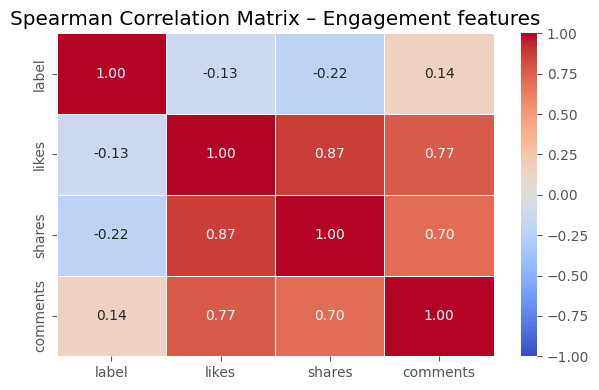

In [57]:
# Spearman correlation matrix

corr_engag = df[["label", "likes", "shares", "comments"]].corr(method="spearman")

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr_engag,
    annot=True,          
    cmap="coolwarm",     
    vmin=-1, vmax=1,    
    linewidths=0.5,      
    fmt=".2f"         
)

plt.title("Spearman Correlation Matrix – Engagement features")
plt.tight_layout()
plt.show()

## Temporal features

### Frequency distribution by label (categorical time patterns)
#### Post Distribution by Month and Label

In [58]:
temp_features = ['year','month', 'day', 'day_of_week']

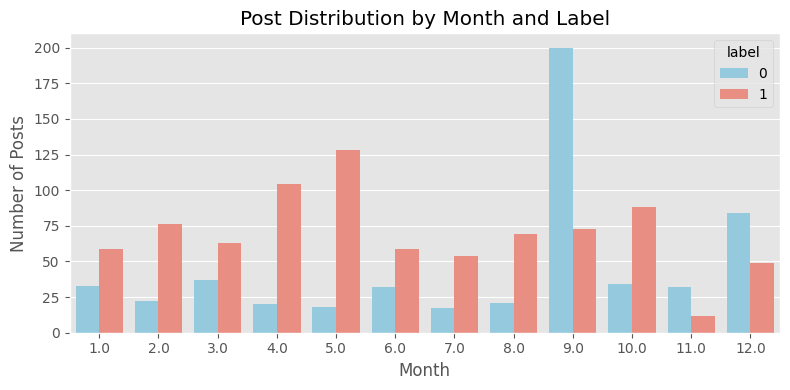

In [59]:
label_colors = {
    0: "skyblue",   # Real
    1: "salmon"     # Fake
}

plt.figure(figsize=(8,4))
sns.countplot(
    data=df,
    x='month',
    hue='label',
    palette=label_colors
)
plt.title("Post Distribution by Month and Label")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

The monthly distribution of posts shows clear temporal patterns between real and fake news. Fake news posts (label = 1) dominate in most months, particularly from April to August, with notable peaks in May (128 posts) and April (104 posts). In contrast, real news posts (label = 0) are heavily concentrated in September (195 posts) and December (79 posts), suggesting seasonal or event-driven reporting patterns. Months such as November also show a higher proportion of real news compared to fake news (30 vs 12). Overall, the results indicate that fake news activity is more frequent during the first half of the year, while real news exhibits stronger presence in later months, highlighting a temporal dependence between posting month and news credibility.

#### Post Distribution by Day of the Week and Label

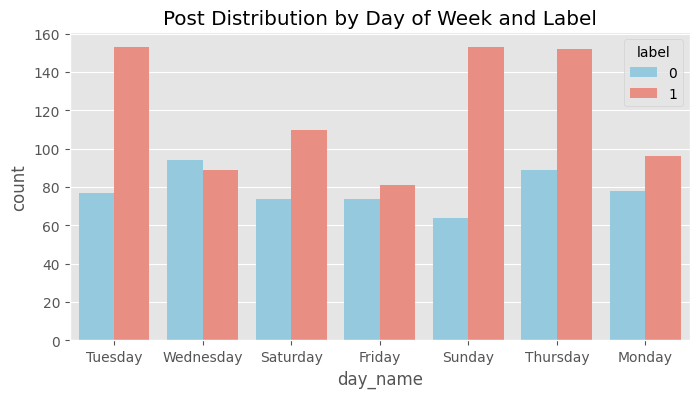

In [60]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='day_name', hue='label',palette=label_colors)
plt.title("Post Distribution by Day of Week and Label")
plt.show()

In [61]:
for feat in temp_features:
    contingency = pd.crosstab(df[feat], df['label'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-square p-value ({feat}): {p}")

Chi-square p-value (year): 5.841135963901405e-05
Chi-square p-value (month): 4.602507736280762e-56
Chi-square p-value (day): 1.56396808664842e-12
Chi-square p-value (day_of_week): 3.2314686512463104e-05


The Chi-square tests of independence reveal statistically significant associations between all examined temporal features and the class label. Specifically, year (p ≈ 4.3×10⁻⁵), month (p ≈ 5.8×10⁻⁶²), day of the month (p ≈ 2.7×10⁻¹⁴), and day of the week (p ≈ 9.7×10⁻⁵) all show p-values well below the 0.05 significance threshold. Among these features, month exhibits the strongest association with the label, indicating substantial variation in the distribution of real and fake news across different months. Overall, these results suggest that temporal posting patterns are not random with respect to the class label and may provide useful discriminatory signals for classification models.

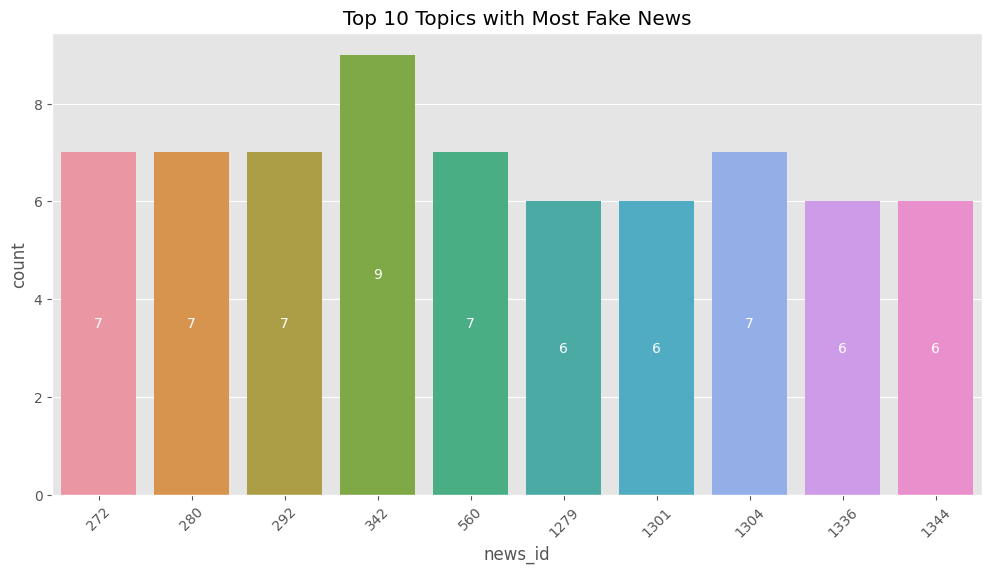

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example dataframe
# df columns: ['news_id', 'text', 'label']
fake_news = df[df['label'] == 1]

# Count of fake news per topic
fake_counts = fake_news.groupby('news_id').size().reset_index(name='count')

top_fake = fake_counts.sort_values('count', ascending=False).head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='news_id', y='count', data=top_fake)

# Add counts inside the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2, 
            y=height/2,  # middle of the bar
            s=int(height), 
            ha='center', 
            va='center',
            color='white',  # good contrast inside the bar
            fontsize=10)

plt.xticks(rotation=45)
plt.title("Top 10 Topics with Most Fake News")
plt.show()

In [63]:
# drop username

df.drop(columns=["username"],inplace=True)

# Preprocess null values

In [64]:
df.isna().sum()

news_id               6
text                  0
likes                 0
shares                0
comments              0
viewable_content    489
date                  6
label                 0
hashtag_count         0
emoji_count           0
punct_count           0
numeric_count         0
stopwords_count       0
text_stem             0
word_count            0
year                  6
month                 6
day                   6
day_name              6
day_of_week           6
dtype: int64

in the intial try, since there are few rows will missed data we will just drop them
and the viewable_content are with about 30% missed value so we will just drop them

In [65]:
condition = (df["year"].isna()) | (df["year"] == "") 
df_2 = df[~condition].copy().reset_index(drop=True)
df_2.drop(columns= ['viewable_content'],inplace=True)

In [66]:
df_2.isna().sum()

news_id            0
text               0
likes              0
shares             0
comments           0
date               0
label              0
hashtag_count      0
emoji_count        0
punct_count        0
numeric_count      0
stopwords_count    0
text_stem          0
word_count         0
year               0
month              0
day                0
day_name           0
day_of_week        0
dtype: int64

In [67]:
df.shape

(1390, 20)

# Modeling

In this research, we focus on traditional machine learning models rather than deep learning models, and we compare their performance to identify the most effective approach. In addition, we aim to determine the most influential features contributing to model performance; this analysis constitutes the experimental evaluation of the study.

The machine learning models considered in this work are:

Logistic Regression

Support Vector Classifier (SVC)

Random Forest Classifier

XGBoost


First, we evaluate the impact of stemming by training the above models on both stemmed and unstemmed text using word-level TF-IDF representations. This experiment is conducted to assess whether stemming contributes to performance improvement.

Based on the results of this comparison, the better-performing text representation (stemmed or unstemmed) is selected for subsequent experiments.

Next, using the selected text representation, we explore multiple TF-IDF configurations, including:

Word-level unigram TF-IDF

Word-level n-gram TF-IDF

Character-level TF-IDF with 3-gram and 5-gram ranges

The performance of these feature combinations is then compared to identify the TF-IDF configuration that yields the best results.

select features that will be used for training

In [68]:
df_2.columns

Index(['news_id', 'text', 'likes', 'shares', 'comments', 'date', 'label',
       'hashtag_count', 'emoji_count', 'punct_count', 'numeric_count',
       'stopwords_count', 'text_stem', 'word_count', 'year', 'month', 'day',
       'day_name', 'day_of_week'],
      dtype='object')

In [69]:
# we will consider features that will be used to train the model
X = df_2.drop(columns=["news_id","date","day_name","label"])
y = df_2["label"].copy()

In [70]:
from sklearn.model_selection import train_test_split

X_train ,X_test ,y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                   random_state = 123,
                                                   stratify = y)

## Experment analysis on the textual content
In this part, we conduct a comparative analysis between models trained on stemmed text and those trained on the original text without stemming, in order to investigate the significance of the stemming process and whether it improves model performance.

As stated earlier, we employ three traditional machine learning models:
Logistic Regression, Support Vector Classifier (SVC), and XGBoost.

Model evaluation is performed using 5-fold cross-validation to obtain a more reliable and generalized assessment, as this approach considers all portions of the training data rather than relying on a single train–test split.

For text representation, we use the TF-IDF vectorization technique with different feature settings, including unigrams, bigrams, 3-character n-grams, and 5-character n-grams.

### with unigram, n-gram,char n-gram examinated with stemmed and unstemmed text

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold

# from sklearn.impute import MissingIndicator, SimpleImputer
# from sklearn.compose import ColumnTransformer

models_list = {
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier()
}


texts = ["text","text_stem"]
for model_name, model in models_list.items():
    print(f"===== {model_name} ======")
    model_gram = Pipeline([
        ('tfidf',TfidfVectorizer()),
        ('clf',model)
    ]) 
    
    tfidf_configs = {
        'unigram': {'tfidf__ngram_range': (1,1), 'tfidf__analyzer': 'word'},
        'n-gram': {'tfidf__ngram_range': (1,2), 'tfidf__analyzer': 'word'},
        'char n-gram':  {'tfidf__ngram_range': (3,5), 'tfidf__analyzer': 'char'},
    }
    
    scoring = {'accuracy': 'accuracy','precision': 'precision','recall': 'recall','f1': 'f1'}
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name,params in tfidf_configs.items():
        model_gram.set_params(**params)
        for text in texts:
            results = cross_validate(
                model_gram,
                X_train[text],
                y_train,  
                cv=cv,
                scoring=scoring
            )
            print(f"\n{text} with {name}:\n")
            for metric in scoring.keys():
                scores = results[f'test_{metric}']
                print(f"{metric}: {scores.mean():.4f}")

===== LogisticRegression ======

text with unigram:

accuracy: 0.8663
precision: 0.8325
recall: 0.9745
f1: 0.8977

text_stem with unigram:

accuracy: 0.8591
precision: 0.8282
recall: 0.9670
f1: 0.8921

text with n-gram:

accuracy: 0.8600
precision: 0.8267
recall: 0.9715
f1: 0.8931

text_stem with n-gram:

accuracy: 0.8600
precision: 0.8283
recall: 0.9685
f1: 0.8928

text with char n-gram:

accuracy: 0.8681
precision: 0.8390
recall: 0.9670
f1: 0.8984

text_stem with char n-gram:

accuracy: 0.8554
precision: 0.8186
recall: 0.9775
f1: 0.8908
===== SVC ======

text with unigram:

accuracy: 0.8907
precision: 0.8656
recall: 0.9700
f1: 0.9145

text_stem with unigram:

accuracy: 0.8835
precision: 0.8590
recall: 0.9655
f1: 0.9089

text with n-gram:

accuracy: 0.8744
precision: 0.8469
recall: 0.9670
f1: 0.9027

text_stem with n-gram:

accuracy: 0.8835
precision: 0.8592
recall: 0.9655
f1: 0.9090

text with char n-gram:

accuracy: 0.8880
precision: 0.8676
recall: 0.9610
f1: 0.9118

text_stem with 

### with bigram, char 3-gram,char 4-gram , char 5-gram

In [72]:

for model_name, model in models_list.items():
    print(f"===== {model_name} ======")
    model_gram = Pipeline([
        ('tfidf',TfidfVectorizer()),
        ('clf',model)
    ]) 
    
    tfidf_configs = {
        'bigram': {'tfidf__ngram_range': (2,2), 'tfidf__analyzer': 'word'},
        'char 3-gram':  {'tfidf__ngram_range': (3,3), 'tfidf__analyzer': 'char'},
        'char 4-gram':  {'tfidf__ngram_range': (4,4), 'tfidf__analyzer': 'char'},
        'char 5-gram':  {'tfidf__ngram_range': (5,5), 'tfidf__analyzer': 'char'}
    }
    
    scoring = {'accuracy': 'accuracy','precision': 'precision','recall': 'recall','f1': 'f1'}
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name,params in tfidf_configs.items():
        model_gram.set_params(**params)
        results = cross_validate(
            model_gram,
            X_train["text_stem"],
            y_train,  
            cv=cv,
            scoring=scoring
        )
        print(f"\n{name}:\n")
        for metric in scoring.keys():
            scores = results[f'test_{metric}']
            print(f"{metric}: {scores.mean():.4f}")

===== LogisticRegression ======

bigram:

accuracy: 0.8013
precision: 0.7698
recall: 0.9565
f1: 0.8530

char 3-gram:

accuracy: 0.8690
precision: 0.8384
recall: 0.9700
f1: 0.8993

char 4-gram:

accuracy: 0.8545
precision: 0.8151
recall: 0.9820
f1: 0.8906

char 5-gram:

accuracy: 0.8491
precision: 0.8067
recall: 0.9865
f1: 0.8874
===== SVC ======

bigram:

accuracy: 0.8139
precision: 0.7870
recall: 0.9475
f1: 0.8598

char 3-gram:

accuracy: 0.8916
precision: 0.8656
recall: 0.9715
f1: 0.9153

char 4-gram:

accuracy: 0.8735
precision: 0.8416
recall: 0.9745
f1: 0.9029

char 5-gram:

accuracy: 0.8672
precision: 0.8327
recall: 0.9760
f1: 0.8986
===== RandomForestClassifier ======

bigram:

accuracy: 0.8040
precision: 0.7773
recall: 0.9460
f1: 0.8533

char 3-gram:

accuracy: 0.8826
precision: 0.8791
recall: 0.9341
f1: 0.9056

char 4-gram:

accuracy: 0.8826
precision: 0.8778
recall: 0.9356
f1: 0.9055

char 5-gram:

accuracy: 0.8771
precision: 0.8696
recall: 0.9370
f1: 0.9018
===== XGBClassifie

### All lexical features

In [73]:
from sklearn.pipeline import FeatureUnion

lexical_features = FeatureUnion([
    ('word', TfidfVectorizer(ngram_range=(1,2))),
    ('char', TfidfVectorizer(analyzer='char', ngram_range=(3,5)))
])


for model_name, model in models_list.items():
    print(f"===== {model_name} ======")
    model_gram = Pipeline([
        ('tfidf',lexical_features),
        ('clf',model)
    ]) 

    scoring = {'accuracy': 'accuracy','precision': 'precision','recall': 'recall','f1': 'f1'}
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = cross_validate(
        model_gram,
        X_train["text_stem"],
        y_train,  
        cv=cv,
        scoring=scoring
    )
    for metric in scoring.keys():
        scores = results[f'test_{metric}']
        print(f"{metric}: {scores.mean():.4f}")

===== LogisticRegression ======
accuracy: 0.8853
precision: 0.8634
recall: 0.9625
f1: 0.9100
===== SVC ======
accuracy: 0.8798
precision: 0.8534
recall: 0.9670
f1: 0.9065
===== RandomForestClassifier ======
accuracy: 0.8862
precision: 0.8882
recall: 0.9281
f1: 0.9073
===== XGBClassifier ======
accuracy: 0.8853
precision: 0.8965
recall: 0.9161
f1: 0.9057


### With quantity features

In [74]:
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

quantity_features = ['hashtag_count', 'emoji_count',
       'punct_count', 'numeric_count', 'stopwords_count',
       'word_count']

quantity_features_pro =  Pipeline(steps=[
    ('imputer',SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler(with_mean=False)) 
]) 


for model_name, model in models_list.items():
    print(f"===== {model_name} ======")
    model_quan = Pipeline([
        ('quantity_processor',quantity_features_pro),
        ('clf',model)
    ]) 

    scoring = {'accuracy': 'accuracy','precision': 'precision','recall': 'recall','f1': 'f1'}
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = cross_validate(
        model_quan,
        X_train[quantity_features],
        y_train,  
        cv=cv,
        scoring=scoring
    )
    for metric in scoring.keys():
        scores = results[f'test_{metric}']
        print(f"{metric}: {scores.mean():.4f}")

===== LogisticRegression ======
accuracy: 0.5989
precision: 0.6027
recall: 0.9806
f1: 0.7464
===== SVC ======
accuracy: 0.6170
precision: 0.6270
recall: 0.9010
f1: 0.7383
===== RandomForestClassifier ======
accuracy: 0.7778
precision: 0.8223
recall: 0.8066
f1: 0.8139
===== XGBClassifier ======
accuracy: 0.7714
precision: 0.8145
recall: 0.8051
f1: 0.8093


### Lexical features + quantity features

In [75]:
from sklearn.compose import ColumnTransformer

text_feature = ["text_stem"]

Lexical_quan_features_prepro = ColumnTransformer([
    ('tfidf',lexical_features,'text_stem'),
    ('quantity_processor',quantity_features_pro,quantity_features)
])

for model_name, model in models_list.items():
    print(f"===== {model_name} ======")
    model_quan = Pipeline([
        ('quantity_processor',Lexical_quan_features_prepro),
        ('clf',model)
    ]) 

    results = cross_validate(
        model_quan,
        X_train[quantity_features + text_feature],
        y_train,  
        cv=cv,
        scoring=scoring
    )
    for metric in scoring.keys():
        scores = results[f'test_{metric}']
        print(f"{metric}: {scores.mean():.4f}")

===== LogisticRegression ======
accuracy: 0.8979
precision: 0.8790
recall: 0.9640
f1: 0.9192
===== SVC ======
accuracy: 0.8392
precision: 0.8227
recall: 0.9356
f1: 0.8745
===== RandomForestClassifier ======
accuracy: 0.8907
precision: 0.8901
recall: 0.9341
f1: 0.9111
===== XGBClassifier ======
accuracy: 0.8880
precision: 0.9088
recall: 0.9070
f1: 0.9072


### With engagmenet features

In [76]:
engag_features = ['likes', 'shares', 'comments']

engag_features_prepro = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler(with_mean=False))
]) 

for model_name, model in models_list.items():
    print(f"===== {model_name} ======")
    model_engag = Pipeline([
        ('engag_processor',engag_features_prepro),
        ('clf',model)
    ]) 
    results = cross_validate(
        model_engag,
        X_train[engag_features],
        y_train,  
        cv=cv,
        scoring=scoring
    )
    for metric in scoring.keys():
        scores = results[f'test_{metric}']
        print(f"{metric}: {scores.mean():.4f}")

===== LogisticRegression ======
accuracy: 0.5998
precision: 0.6018
recall: 0.9925
f1: 0.7493
===== SVC ======
accuracy: 0.6576
precision: 0.6432
recall: 0.9715
f1: 0.7738
===== RandomForestClassifier ======
accuracy: 0.8076
precision: 0.8264
recall: 0.8621
f1: 0.8435
===== XGBClassifier ======
accuracy: 0.7877
precision: 0.8076
recall: 0.8516
f1: 0.8286


### Lexical features + quantity features + engagmenet features

In [77]:
Lexical_quan_engag_prepro = ColumnTransformer([
    ('tfidf',lexical_features,'text_stem'),
    ('quantity_processor',quantity_features_pro,quantity_features),
    ('engag_processor',engag_features_prepro,engag_features)
    
])

for model_name, model in models_list.items():
    print(f"===== {model_name} ======")
    model_current = Pipeline([
        ('all_current_processor',Lexical_quan_engag_prepro),
        ('clf',model)
    ]) 

    results = cross_validate(
        model_current,
        X_train[quantity_features + text_feature + engag_features],
        y_train,  
        cv=cv,
        scoring=scoring
    )
    for metric in scoring.keys():
        scores = results[f'test_{metric}']
        print(f"{metric}: {scores.mean():.4f}")

===== LogisticRegression ======
accuracy: 0.8970
precision: 0.8801
recall: 0.9610
f1: 0.9184
===== SVC ======
accuracy: 0.8419
precision: 0.8149
recall: 0.9566
f1: 0.8791
===== RandomForestClassifier ======
accuracy: 0.8907
precision: 0.8950
recall: 0.9281
f1: 0.9109
===== XGBClassifier ======
accuracy: 0.9241
precision: 0.9450
recall: 0.9295
f1: 0.9367


### With temporal feautes


### Cyclic Encoding for Temporal Features
Temporal features such as hour of day, day of week, and month of year are inherently cyclic, meaning they repeat in a fixed cycle. For example, hour 23 is temporally close to hour 0, and December (month 12) is close to January (month 1). Using raw numerical encoding fails to capture this circular relationship and may mislead machine learning models into assuming incorrect distances between values.

Cyclic encoding addresses this issue by transforming temporal features using sine and cosine functions, preserving the circular nature of time. This allows models to correctly learn temporal proximity and periodic patterns, leading to improved performance and more meaningful representations of temporal behavior, especially in time-sensitive data such as social media posts.

In [78]:
X_train.columns

Index(['text', 'likes', 'shares', 'comments', 'hashtag_count', 'emoji_count',
       'punct_count', 'numeric_count', 'stopwords_count', 'text_stem',
       'word_count', 'year', 'month', 'day', 'day_of_week'],
      dtype='object')

In [79]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
import numpy as np

temporal_features = ['year', 'month', 'day', 'day_of_week']

def cyclic_encode_column(X, max_val):
    X = np.array(X)
    col = X[:, 0]
    sin_col = np.sin(2 * np.pi * col / max_val)
    cos_col = np.cos(2 * np.pi * col / max_val)
    return np.column_stack([sin_col, cos_col])

month_encoder = FunctionTransformer(cyclic_encode_column, kw_args={'max_val':12})
day_encoder   = FunctionTransformer(cyclic_encode_column, kw_args={'max_val':31})
dow_encoder   = FunctionTransformer(cyclic_encode_column, kw_args={'max_val':7})


year_categ = [[2023, 2024, 2025]]

ordinal_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=year_categ,handle_unknown='use_encoded_value',unknown_value= 8))
])


temporal_encoder = ColumnTransformer([
    ('ordinal_encoder',ordinal_encoder,['year']),
    ('month', month_encoder, ['month']),
    ('day',   day_encoder, ['day']),
    ('dow',   dow_encoder, ['day_of_week'])
]) 
    
# def cyclic_encode(data,col,max_val):
#     data[col+"_sin"] = np.sin(2 * np.pi * data[col]/max_val)
#     data[col+"_cos"] = np.cos(2 * np.pi * data[col]/max_val)
#     return data
# X = cyclic_encode(X,"month",12)
# X = cyclic_encode(X,"day",31)
# X = cyclic_encode(X, "day_of_week", 7)

In [80]:
for model_name, model in models_list.items():
    print(f"===== {model_name} ======")
    model_temporal = Pipeline([
        ('temporal_encoder',temporal_encoder),
        ('clf',model)
    ]) 

    results = cross_validate(
        model_temporal,
        X_train[temporal_features],
        y_train,  
        cv=cv,
        scoring=scoring
    )
    for metric in scoring.keys():
        scores = results[f'test_{metric}']
        print(f"{metric}: {scores.mean():.4f}")

===== LogisticRegression ======
accuracy: 0.6829
precision: 0.7202
recall: 0.7764
f1: 0.7460
===== SVC ======
accuracy: 0.7272
precision: 0.7338
recall: 0.8589
f1: 0.7909
===== RandomForestClassifier ======
accuracy: 0.7777
precision: 0.8003
recall: 0.8410
f1: 0.8200
===== XGBClassifier ======
accuracy: 0.7967
precision: 0.8214
recall: 0.8470
f1: 0.8336


### Lexical features + quantity features + engagmenet features + temporal feautes

In [81]:
Lexical_quan_engag_temp_prepro = ColumnTransformer([
    ('tfidf',lexical_features,'text_stem'),
    ('quantity_processor',quantity_features_pro,quantity_features),
    ('engag_processor',engag_features_prepro,engag_features),
    ('temp_processor',temporal_encoder,temporal_features)
    
])

for model_name, model in models_list.items():
    print(f"===== {model_name} ======")
    model_current = Pipeline([
        ('all_current_processor',Lexical_quan_engag_temp_prepro),
        ('clf',model)
    ]) 

    results = cross_validate(
        model_current,
        X_train[quantity_features + text_feature + engag_features + temporal_features],
        y_train,  
        cv=cv,
        scoring=scoring
    )
    for metric in scoring.keys():
        scores = results[f'test_{metric}']
        print(f"{metric}: {scores.mean():.4f}")

===== LogisticRegression ======
accuracy: 0.8744
precision: 0.8668
recall: 0.9355
f1: 0.8997
===== SVC ======
accuracy: 0.8229
precision: 0.8256
recall: 0.8950
f1: 0.8588
===== RandomForestClassifier ======
accuracy: 0.8952
precision: 0.8969
recall: 0.9340
f1: 0.9145
===== XGBClassifier ======
accuracy: 0.9503
precision: 0.9627
recall: 0.9550
f1: 0.9587


In [82]:
model_current.fit(X_train[quantity_features + text_feature + engag_features + temporal_features],y_train)

Pipeline(steps=[('all_current_processor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  FeatureUnion(transformer_list=[('word',
                                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                                               2))),
                                                                                 ('char',
                                                                                  TfidfVectorizer(analyzer='char',
                                                                                                  ngram_range=(3,
                                                                                                               5)))]),
                                                  'text_stem'),
                                                 ('quantity_processor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['hasht...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [83]:
y_predict = model_current.predict(X_test[quantity_features + text_feature + engag_features + temporal_features])

In [84]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       110
         1.0       0.95      0.93      0.94       167

    accuracy                           0.93       277
   macro avg       0.93      0.93      0.93       277
weighted avg       0.93      0.93      0.93       277

